In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import scTRS.method as md
import matplotlib.pyplot as plt
import scTRS.util as util
import scvi

In [2]:
scvi_trained = True
if scvi_trained:
    adata = sc.read_h5ad("data/vangalen2019_scvi.h5ad")
else:
    adata = sc.read_h5ad("data/vangalen2019.h5ad")
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    sc.pp.highly_variable_genes(
        adata,
        layer="counts",
        batch_key="donor",
        subset=True
    )

    scvi.data.setup_anndata(adata, layer="counts", batch_key="donor")
    vae = scvi.model.SCVI(adata)
    vae.train()
    adata.obsm["X_scVI"] = vae.get_latent_representation()
    adata.obsm["X_normalized_scVI"] = vae.get_normalized_expression()
    del adata.uns['_scvi']

In [3]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

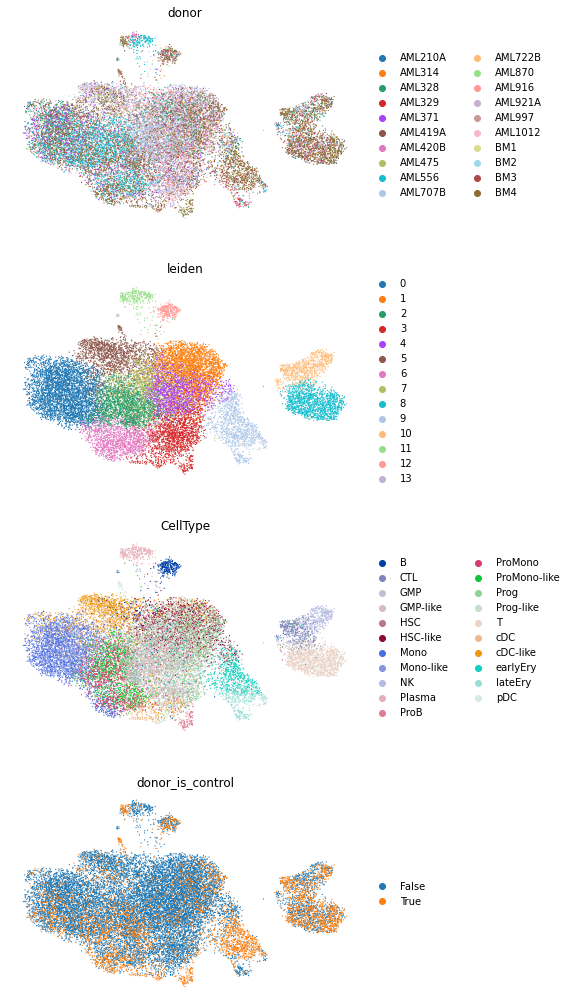

In [4]:
adata.obs["donor_is_control"] = adata.obs["donor"].str.startswith("BM").astype("category")
sc.pl.umap(
    adata,
    color=["donor", "leiden", "CellType", "donor_is_control"],
    frameon=False,
    ncols=1,
)

In [5]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.obsm["X_normalized_scVI"])
GS_FILE = "/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs"
df_gs = pd.read_csv(GS_FILE, sep='\t')
df_gs.index = df_gs['TRAIT']

trait_list = ["PASS_Alzheimers_Jansen2019", "UKB_460K.body_HEIGHTz", "PASS_Lupus", "PASS_Rheumatoid_Arthritis", "UKB_460K.blood_RED_COUNT", "UKB_460K.blood_MONOCYTE_COUNT"]
df_gs = df_gs[df_gs.TRAIT.isin(trait_list)]

In [6]:
df_res_dict = dict()
for trait in df_gs.index:
    print(trait)
    gene_list = df_gs.loc[trait,'GENESET'].split(',')
    df_res = md.score_cell(adata, gene_list, n_ctrl=500, weight_opt="uniform",
                           return_ctrl_raw_score=False, 
                           return_ctrl_norm_score=True,
                           verbose=False)
    df_res_dict[trait] = df_res

PASS_Rheumatoid_Arthritis
PASS_Lupus
UKB_460K.blood_RED_COUNT
PASS_Alzheimers_Jansen2019
UKB_460K.blood_MONOCYTE_COUNT
UKB_460K.body_HEIGHTz


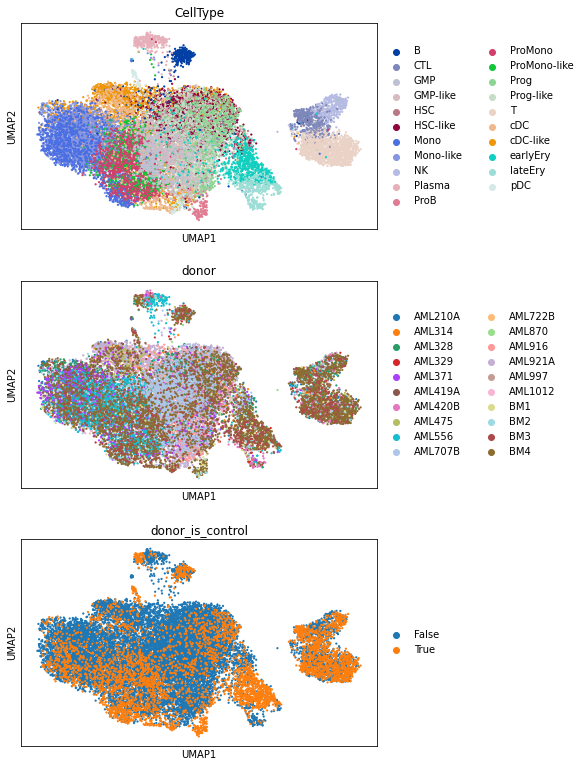

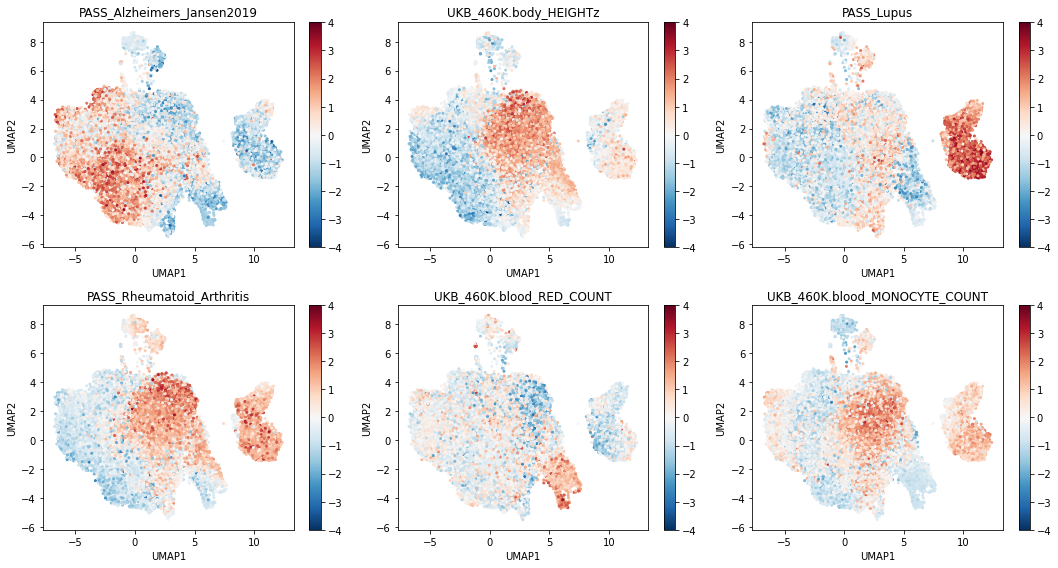

In [7]:
zsc_dict = dict()
for trait in trait_list:
    zsc_dict[trait] = df_res_dict[trait]["zscore"].reindex(adata.obs.index).values
score_index = adata.obs.index
util.plot_score_umap(zsc_dict, score_index, adata, n_col=3, umap_color=["CellType", "donor", "donor_is_control"]) 

In [13]:
# for trait in trait_list:
#     adata.obs[f'trs_{trait}'] = df_res_dict[trait]["zscore"].reindex(adata.obs.index).values
    
# sc.pl.violin(adata, keys=['trs_' + trait for trait in trait_list], groupby='donor_is_control')